# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List
import heapq

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    data = pd.read_csv(path_to_csv)
    data['label'] = data["label"].apply(lambda item: 1 if item == "M" else 0)
    data = data.to_numpy()
    np.random.shuffle(data)
    X = np.delete(data, 0, axis=1)
    y = data[:, 0]
    return X, y

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    data = pd.read_csv(path_to_csv)
    data = data.to_numpy()
    np.random.shuffle(data)
    X = np.delete(data, -1, axis=1)
    y = data[:, -1]
    return X, y

In [3]:
read_cancer_dataset("cancer.csv")

(array([[1.003e+01, 2.128e+01, 6.319e+01, ..., 2.579e-02, 2.349e-01,
         8.061e-02],
        [1.464e+01, 1.524e+01, 9.577e+01, ..., 1.397e-01, 3.151e-01,
         8.473e-02],
        [1.184e+01, 1.870e+01, 7.793e+01, ..., 1.546e-01, 4.761e-01,
         1.402e-01],
        ...,
        [1.754e+01, 1.932e+01, 1.151e+02, ..., 1.939e-01, 2.928e-01,
         7.867e-02],
        [1.334e+01, 1.586e+01, 8.649e+01, ..., 1.708e-01, 3.527e-01,
         1.016e-01],
        [1.254e+01, 1.632e+01, 8.125e+01, ..., 8.411e-02, 3.155e-01,
         7.538e-02]]),
 array([0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [4]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.
    
    """
    train_size = int(ratio * len(X))
    return X[:train_size], y[:train_size], X[train_size:], y[train_size:]




### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [5]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    classes = np.unique(list(y_train) + list(y_test))
    
    precision = [0.0] * len(classes)
    recall    = [0.0] * len(classes)

    for i, y in enumerate(classes):
        true_positive  = sum(1 for p, t in zip(y_pred, y_true) if p == y and t == y)
        false_positive = sum(1 for p, t in zip(y_pred, y_true) if p == y and t != y)
        false_negative = sum(1 for p, t in zip(y_pred, y_true) if p != y and t == y)
        try:
            precision[i] = true_positive / (true_positive + false_positive)
        except ZeroDivisionError:
            precision[i] = 0
        try:
            recall[i]    = true_positive / (true_positive + false_negative)
        except ZeroDivisionError:
            recall[i] = 0
        
    accuracy =  sum(1 for p, t in zip(y_pred, y_true) if p == t) / len(y_pred)
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [6]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [7]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [8]:
class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области,
            в которых не меньше leaf_size точек).

        Returns
        -------

        """
        self.X = X
        self.leaf_size = leaf_size
        self.X_with_inds = np.c_[X, np.arange(len(X))]
        self.kdtree = self.build_tree(self.X_with_inds, leaf_size)
        
    def build_tree(self, X, leaf_size, axis=0):
        num_features = X.shape[1] - 1
        X = X[np.argsort(X[:, axis])]
        node = None
        left = None
        right = None
        mid = X.shape[0] // 2
        if X.shape[0] / 2 > leaf_size:
            node = X[mid]
            left = self.build_tree(X[: mid], leaf_size, axis=(axis + 1) % num_features)
            right = self.build_tree(X[mid + 1:], leaf_size, axis=(axis + 1) % num_features)
        return node, left, right, (None if node is not None else X)

    def find_nearest(self, tree, point, k, i, heap=None):
        is_root = not heap
        node, left, right, leaf = tree
        if is_root:
            heap = []
        if node is not None:
            d = np.linalg.norm(point - node[:-1])
            dx = point[i] - node[i]
            if len(heap) < k:
                heapq.heappush(heap, (-d, int(node[-1]), node[:-1]))
            elif d < -heap[0][0]:
                heapq.heappushpop(heap, (-d, int(node[-1]), node[:-1]))
            i = (i + 1) % (len(node) - 1)
            if dx <= 0 or np.abs(dx) <= -heap[0][0]:
                self.find_nearest(left, point, k, i, heap=heap)
            if dx >= 0 or np.abs(dx) <= -heap[0][0]:
                self.find_nearest(right, point, k, i, heap=heap)
        else:
            for idx, pt in enumerate(leaf):
                d = np.linalg.norm(point - pt[:-1])
                if len(heap) < k:
                    heapq.heappush(heap, (-d, int(pt[-1]), pt[:-1]))
                elif d < -heap[0][0]:
                    heapq.heappushpop(heap, (-d, int(pt[-1]), pt[:-1]))
        if is_root:
            neighbors = sorted((-h[0], h[1], h[2]) for h in heap)
            return [h[1] for h in neighbors]

    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k):
            индексы k ближайших соседей для всех точек из X.

        """
        ans = []
        for point in X:
            to_app = self.find_nearest(self.kdtree, point, k, 0)
            ans.append(to_app)
        return ans

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [9]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape", np.array(predicted).shape, np.array(true).shape)
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors", "\n", predicted, "\n", true)

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [10]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.kdtree = None
        self.y = None
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """
        self.kdtree = KDTree(X, leaf_size=self.leaf_size)
        self.y = y
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        knns = np.array(self.kdtree.query(X, self.n_neighbors))
        labels = (lambda idx: self.y[idx])(knns)
        
        classes = np.unique(self.y)
        
        ans = []
        for point in labels:
            res = np.zeros(len(classes))
            for i, c in enumerate(classes):
                res[i] = np.count_nonzero(point == c)
            res = res / len(point)
            ans.append(res)
        return np.array(ans)
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

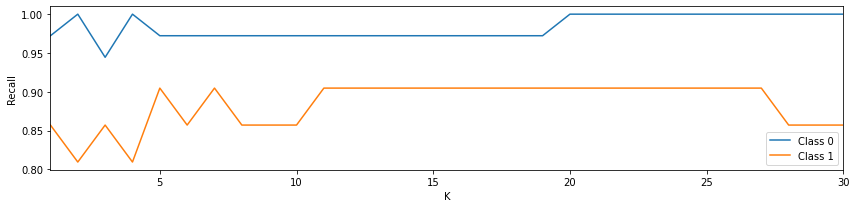

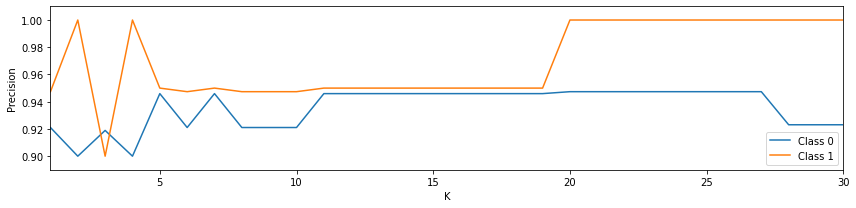

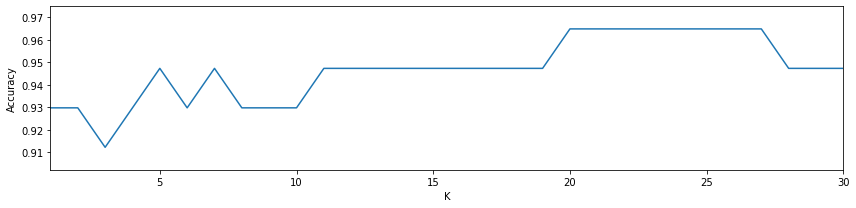

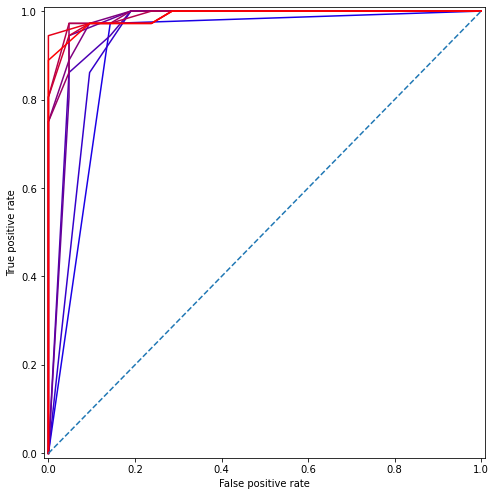

In [11]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

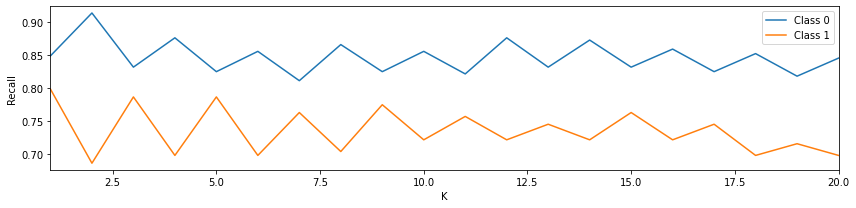

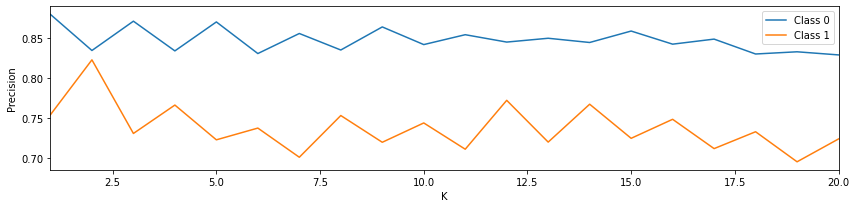

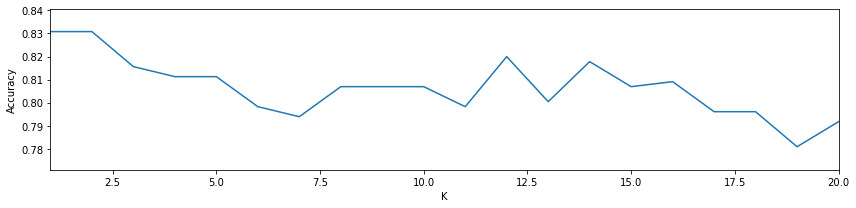

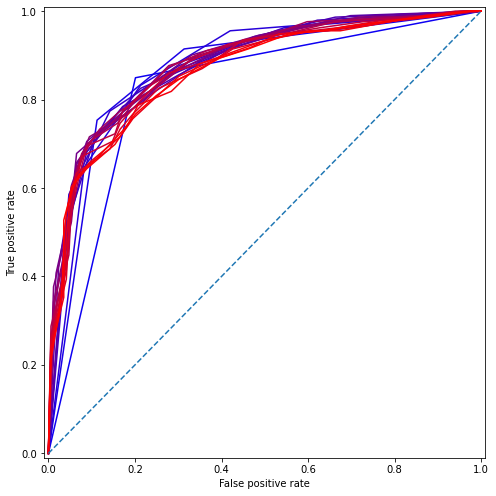

In [12]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)